<a href="https://colab.research.google.com/github/angelamejia804/TimeSeries/blob/main/Copia_de_Modelo_Recepcion_Sarima_3_2020_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from time import time
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')


mpl.rcParams['figure.figsize'] = (11, 4)
mpl.rcParams['axes.grid'] = False

import statsmodels.api as sm

plt.style.use('fivethirtyeight')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [3]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00


In [4]:
from pmdarima.arima import auto_arima

# **Parametros estacionales**



1.   p : Orden autorregresivo.
2.   d : Orden de diferenciación.
3.   q : Orden de la media móvil.


# Parametros de temporada

*   P : Orden autorregresivo estacional.
*   D : Orden de diferenciación estacional.
*   P : Orden promedio móvil estacional
*   S : Duración del ciclo estacional.

https://www-jadsmkbdatalab-nl.translate.goog/forecasting-with-sarimax-models/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=wapp


BASE DE DATOS DE RECEPCIÓN

Cargamos el archivo que se dejo preparado en el notebook
https://github.com/angelamejia804/TimeSeries/blob/main/Preparacion_TimeSeries_Recepcion_2_1.ipynb



In [43]:
from google.colab import files
uploaded = files.upload()

Saving df_recepcion_traint.csv to df_recepcion_traint (1).csv


In [98]:
df_r = pd.read_csv("df_recepcion_traint.csv", delimiter=';',index_col='Semana')

In [99]:
df_r = df_r['2020-W01':]

In [101]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series

    Args:
        time_series (df): Dataframe of univariate time series
        max_d (int): Max value of how many times apply difference

    Return:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times
        differencing on a time-series.

    """

    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True

        stationary = adf_stationary & kpss_stationary

        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))

    # Construct DataFrame
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])

    return results_df
    #esta funcion fue tomada de

In [103]:
df_r.head()

,Tallos
Semana,
2020-W01,91939
2020-W02,200892
2020-W03,676003
2020-W04,1288302
2020-W05,507192


In [104]:
df_r.describe()

,Tallos
count,1.560000e+02
mean,2.823053e+05
std,1.786500e+05
min,7.213600e+04
25%,1.765635e+05
50%,2.378650e+05
75%,3.066048e+05
max,1.288302e+06


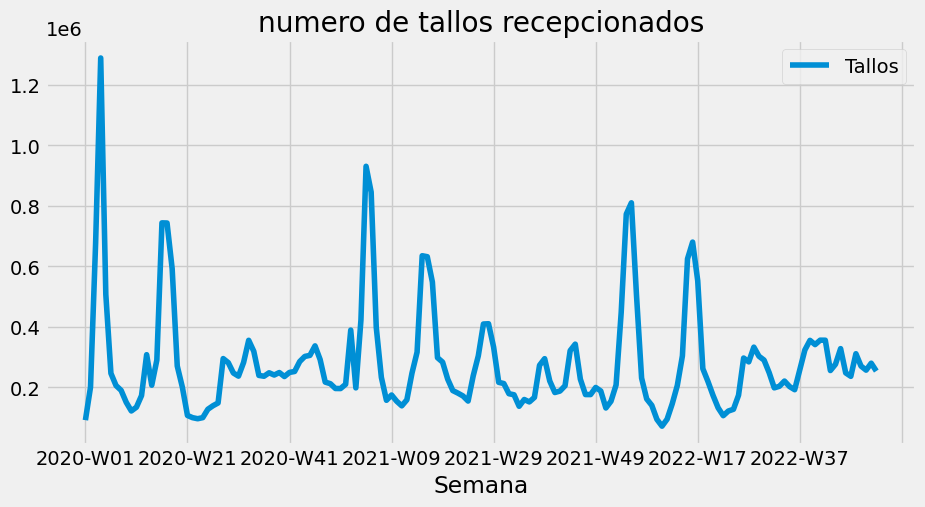

In [105]:
# Plot the entire time series diet and show gridlines
df_r.plot(figsize=(10,5), title = "numero de tallos recepcionados" )
plt.show()

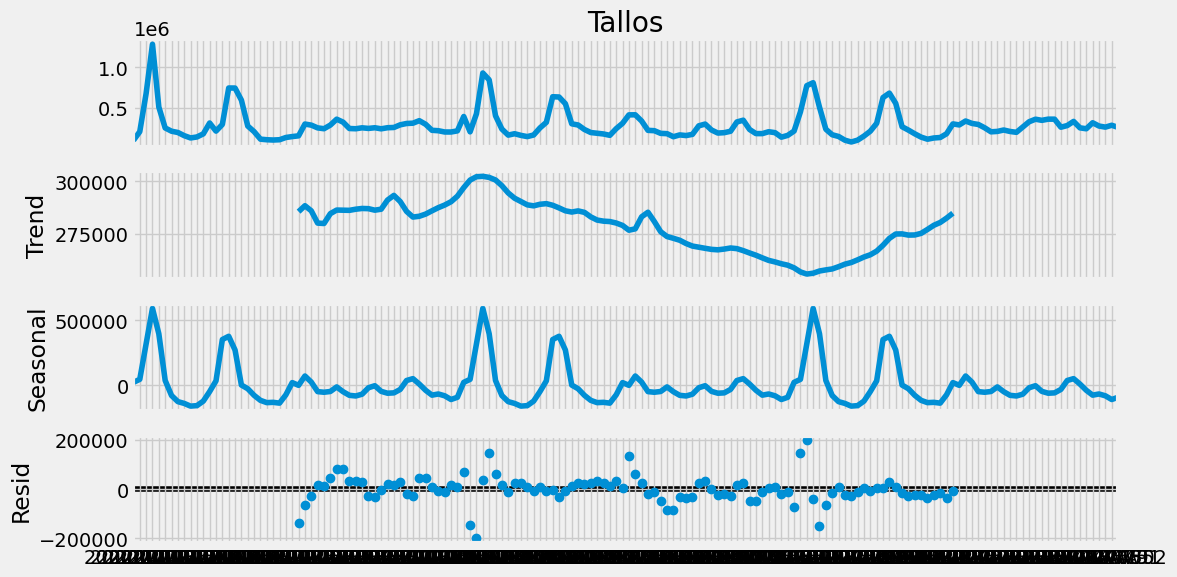

In [106]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_r['Tallos'],
                                        # model = 'multiplicative', #   model = 'aditive',
                                         period=52 #52 to 53 weeks in a year
                                         )
fig = decomposition.plot()
plt.show()

pruebas para determinar si la serie es

In [107]:
obtain_adf_kpss_results(df_r,3) #no se requiere ya que con d=0 cumple

,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,1.436258e-02,0.1,True,True,True
1,1,6.355873e-17,0.1,True,True,True
2,2,3.249296e-11,0.1,True,True,True


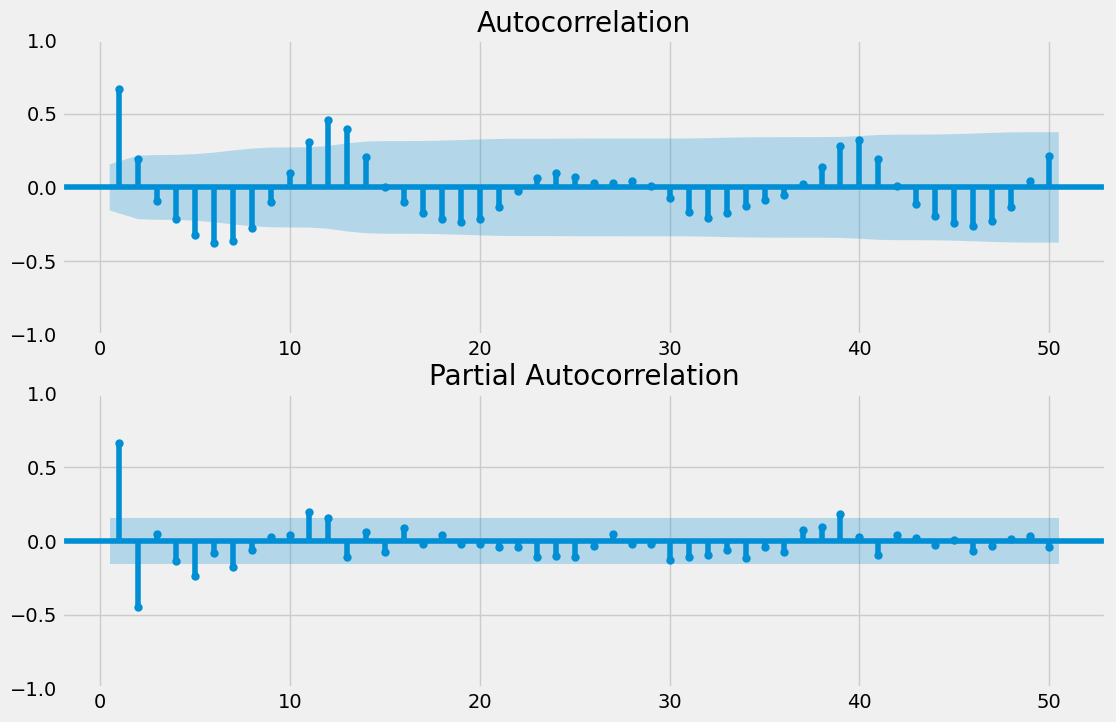

In [108]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_r,lags=50, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_r,lags=50, zero=False, ax=ax2)

plt.show()



Probemos definir el modelo con a traves de los criterios AIC y BIC



In [109]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-6
for p in range(8):
  # Loop over q values from 0-6
    for q in range(7):
      	#  fit ARMA(p,q) model
        model = SARIMAX(df_r, order=(p,0,q),  Frequency='W') #
        results = model.fit()

        #
        order_aic_bic.append((p,q,results.aic, results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p','q','AIC','BIC'])

In [110]:
order_df.sort_values('AIC')# 3	1	4103.791292	4119.040572  / 3	1	4103.791292	4119.040572

,p,q,AIC,BIC
43,6,1,4103.406637,4127.805485
50,7,1,4103.567862,4131.016567
22,3,1,4103.791292,4119.040572
51,7,2,4108.148141,4138.646701
44,6,2,4110.795607,4138.244311
27,3,6,4111.135782,4141.634342
10,1,3,4112.397006,4127.646286
55,7,6,4115.466104,4158.164089
23,3,2,4115.535551,4133.834687
17,2,3,4117.466527,4135.765663


In [111]:
order_df.sort_values('BIC')

,p,q,AIC,BIC
22,3,1,4103.791292,4119.040572
10,1,3,4112.397006,4127.646286
43,6,1,4103.406637,4127.805485
50,7,1,4103.567862,4131.016567
23,3,2,4115.535551,4133.834687
16,2,2,4119.640127,4134.889407
17,2,3,4117.466527,4135.765663
44,6,2,4110.795607,4138.244311
51,7,2,4108.148141,4138.646701
27,3,6,4111.135782,4141.634342


In [131]:
arima_model = SARIMAX(df_r, order=(3,0,1))   #  (3,0,1))
# fit model
arima_results = arima_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 75353.748


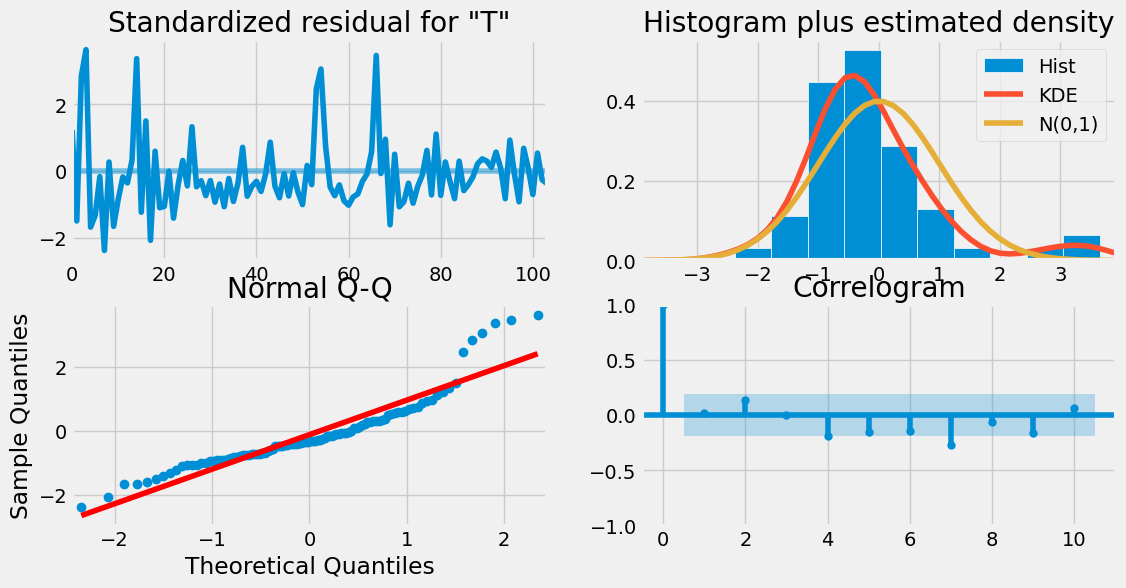

In [112]:
arima_results.plot_diagnostics()
plt.show()

In [152]:
sarima_01_model = SARIMAX(df_r, order=(1,0,2), seasonal_order=(1,0,3,52))
sarima_01_results = sarima_01_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_01_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 77682.613


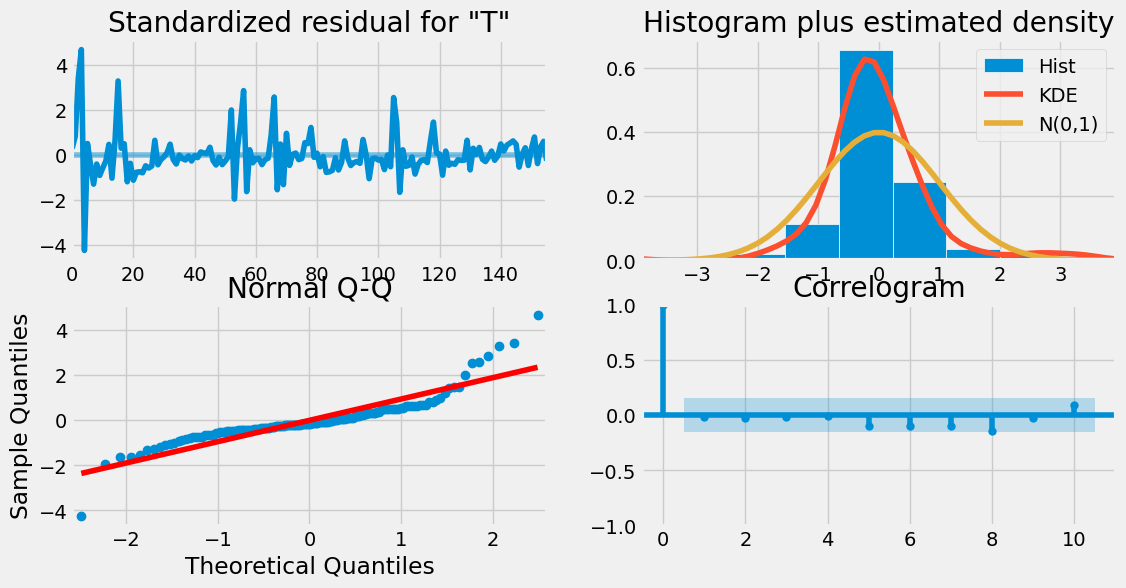

In [115]:
sarima_01_results.plot_diagnostics()
plt.show()

hacemos un intento a traves de la seleccion automatizada - Auto Arima

In [116]:
from pmdarima.arima.arima import pmdarima
sarima_02_model=pmdarima.auto_arima(df_r, #time series
                      seasonal=True, # is the time series seasonal
                      m=52, # the seasonal period - 53  weeks?
                      d=0, # non-seasonal difference order
                      D=0, # seasonal difference order
                 	  max_p=6, # max value of p to test
                      max_q=6, # max value of p to test
                      max_P=6, # max value of P to test
                      max_Q=6, # max value of Q to test
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True)

# Print model summary
print(sarima_02_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=4069.408, Time=4.30 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4218.779, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4103.747, Time=1.25 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4106.712, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4412.797, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=10.49 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=4067.902, Time=3.21 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=4132.682, Time=0.20 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=4066.755, Time=19.83 sec
 ARIMA(2,0,2)(3,0,0)[52] intercept   : AIC=4065.391, Time=54.86 sec
 ARIMA(2,0,2)(4,0,0)[52] intercept   : AIC=4067.358, Time=175.48 sec
 ARIMA(2,0,2)(3,0,1)[52] intercept   : AIC=4067.356, Time=94.70 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=4066.180, Time=26.51 sec
 ARIMA(2,0,2)(4,0,1)[52] intercept   : AIC=4069.401, Time=309.93 sec
 ARIMA(1,0,2)(3

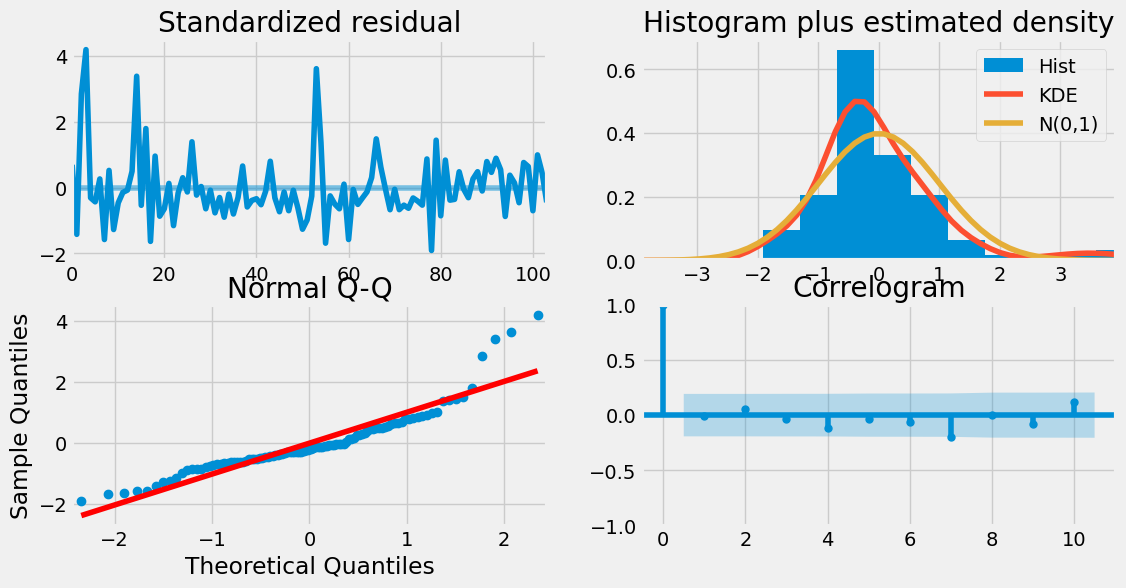

In [91]:
sarima_02_model.plot_diagnostics()
plt.show()

Best model:  ARIMA(2,0,0)(2,0,0)[53] intercept

Best model:  ARIMA(2,0,0)(2,0,0)[53] intercept

1.   Elemento de lista
2.   Best model:  ARIMA(1,0,2)(1,0,0)[52] intercept   - datos 2021-2022



---





In [151]:
sarima_02_model = SARIMAX(df_r, order=(2,1,3), seasonal_order=(2,0,3,52))
sarima_02_results = sarima_02_model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima_02_results.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 70642.050


In [153]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_prediction(start=-30, dynamic=True)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_01_pred = sarima_01_results.get_prediction(start=-30, dynamic=True)
sarima_01_mean = sarima_01_pred.predicted_mean

#autorarima

sarima_02_pred = sarima_02_results.get_prediction(start=-30, dynamic=True)
sarima_02_mean = sarima_02_pred.predicted_mean


In [161]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

metrics_arima = [round(mean_absolute_error(df_r[-30:],arima_mean),3),
                 round(mean_absolute_percentage_error(df_r[-30:],arima_mean),3)]

metrics_sarima_01 = [round(mean_absolute_error(df_r[-30:],sarima_01_mean),3),
                       round(mean_absolute_percentage_error(df_r[-30:],sarima_01_mean),3)]

metrics_sarima_02 = [round(mean_absolute_error(df_r[-30:],sarima_02_mean),3),
                       round(mean_absolute_percentage_error(df_r[-30:],sarima_02_mean),3)]



In [155]:
y_true = df_r[-30:]  # Valores reales de la serie de tiempo
r2_Arima = round(r2_score(y_true, arima_mean), 3)
r2__sarima_01 = round(r2_score(y_true, sarima_01_mean), 3)
r2__sarima_02 = round(r2_score(y_true,sarima_02_mean), 3)


In [156]:
print(metrics_arima)
print(metrics_sarima_01)
print(metrics_sarima_02)

[49191.889, 0.224]
[42721.911, 0.159]
[40703.875, 0.151]


In [157]:
print(r2_Arima)
print(r2__sarima_01)
print(r2__sarima_02)

0.098
0.209
0.262


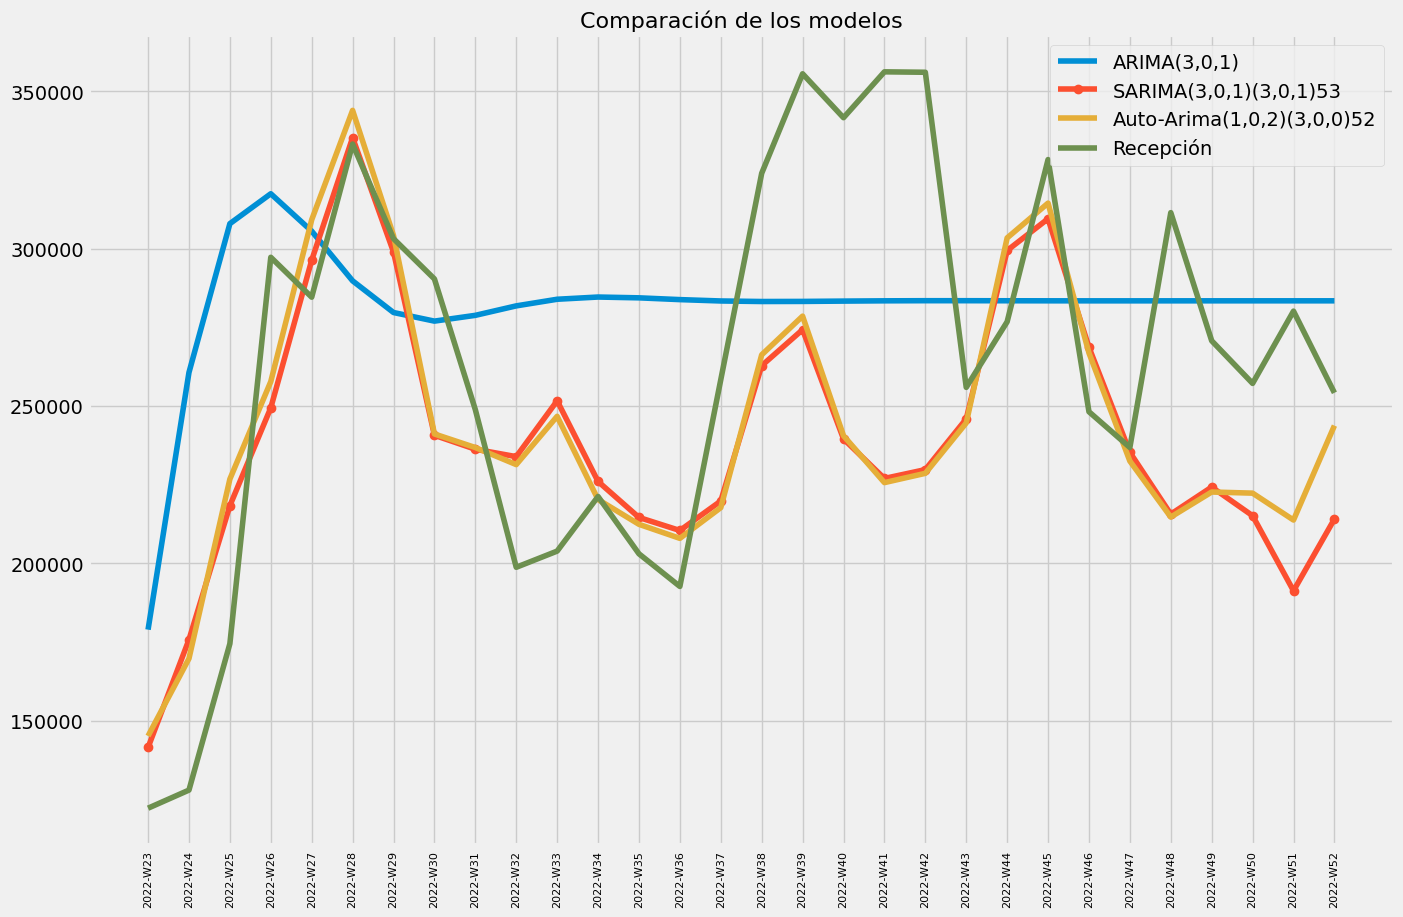

In [158]:
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
dates = df_r.index
#comparamos los modelos contra los valores observados
plt.figure(figsize=(15,10))
plt.title('Comparación de los modelos', size = 16)
plt.plot(arima_mean.index, arima_mean, label='ARIMA(3,0,1)')
plt.plot(sarima_01_mean.index, sarima_01_mean, label='SARIMA(3,0,1)(3,0,1)53', marker='o')
plt.plot(sarima_02_mean.index, sarima_02_mean, label='Auto-Arima(1,0,2)(3,0,0)52') #
plt.plot(df_r[-30:], label='Recepción')


# Ajustar el tamaño de las etiquetas del eje X
plt.xticks(rotation=90, fontsize=8)  # Ajusta el tamaño a tu preferencia



plt.legend()
plt.show()

In [129]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=13)
arima_mean = arima_pred.predicted_mean


In [130]:
arima_mean

156    254709.573182
157    266837.581694
158    278391.315680
159    284213.559906
160    284716.809484
161    282605.801529
162    280327.416741
163    279053.868185
164    278832.565783
165    279186.060390
166    279628.722097
167    279901.391067
168    279968.867573
Name: predicted_mean, dtype: float64